Mean Squared Error: 0.10
Mean Absolute Error: 0.26
R^2 Score: 0.95

Feature Importances:
                           Feature  Importance
21            Disease (Yes/No)_Yes    0.349259
9         Harmful_Microbes (CFU/g)    0.301279
12                Variety_SK Local    0.147288
8      Beneficial_Microbes (CFU/g)    0.053402
22        Disease_Name_Spindle Bug    0.051832
13            Variety_Shreemangala    0.019971
10             Soil_Organic_Carbon    0.017762
14               Variety_Sumangala    0.015981
24   Nutrient_Deficiency_Potassium    0.006028
23  Nutrient_Deficiency_Phosphorus    0.005321
17          Microbial_Activity_Low    0.003512
18     Microbial_Activity_Moderate    0.003185
3                    K (Potassium)    0.003098
2                   P (Phosphorus)    0.002459
11      Microbial_Biomass_C (g/kg)    0.002354
19        Soil_Enzyme_Activity_Low    0.002140
1                     N (Nitrogen)    0.001960
6                    Rainfall (mm)    0.001757
4      Organic_Mat

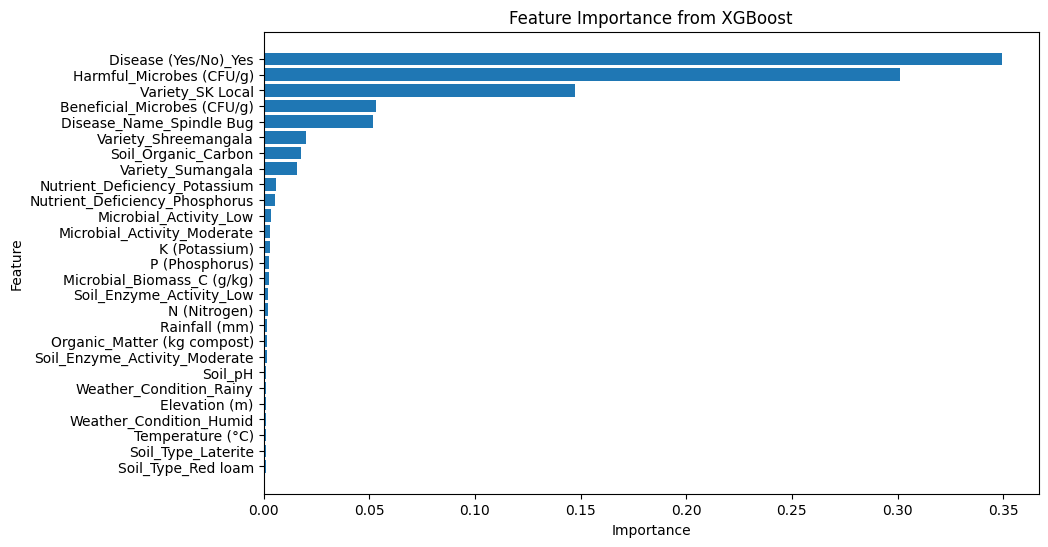

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Load the dataset
df = pd.read_csv('C:/Users/kunji/OneDrive/Desktop/data/augmented_arecanut_dataset5k.csv')

# Preprocessing function to convert scientific notation
def convert_scientific_notation(x):
    if isinstance(x, str) and 'x 10' in x:
        parts = x.split('x 10^')
        return float(parts[0]) * (10 ** int(parts[1]))
    return float(x)

# Convert scientific notation to float
df['Beneficial_Microbes (CFU/g)'] = df['Beneficial_Microbes (CFU/g)'].apply(convert_scientific_notation)
df['Harmful_Microbes (CFU/g)'] = df['Harmful_Microbes (CFU/g)'].apply(convert_scientific_notation)
df['Soil_Organic_Carbon'] = df['Soil_Organic_Carbon'].str.replace('%', '').astype(float) / 100.0

# Define numeric columns
numeric_cols = [
    'Soil_pH', 'N (Nitrogen)', 'P (Phosphorus)', 'K (Potassium)', 
    'Organic_Matter (kg compost)', 'Temperature (°C)', 'Rainfall (mm)', 
    'Elevation (m)', 'Beneficial_Microbes (CFU/g)', 'Harmful_Microbes (CFU/g)', 
    'Microbial_Biomass_C (g/kg)', 'Soil_Organic_Carbon'
]

# Convert to numeric and handle errors
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Fill missing values with column means
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# Encode categorical variables
df = pd.get_dummies(df, drop_first=True)

# Split data into features and target variable, excluding Sample_ID
X = df.drop(['Crop_Yield (kg/palm)', 'Sample_ID'], axis=1)
y = df['Crop_Yield (kg/palm)']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define and train the XGBoost model
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=10,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42
)

# Fit the model
xgb_model.fit(X_train_scaled, y_train)

# Predicting the yields for test data
y_pred = xgb_model.predict(X_test_scaled)

# Calculate and print performance metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R^2 Score: {r2:.2f}")

# Feature Importances
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)

# Optionally: Plotting feature importances
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from XGBoost')
plt.gca().invert_yaxis()
plt.show()


In [2]:
test_input_data = {
    'Variety_SK Local': [0],
    'Variety_Shreemangala': [0],
    'Variety_Sumangala': [1],
    'Variety_Mangala': [0],  # Include Mangala variety only
    'Soil_pH': [6.5],
    'N (Nitrogen)': [108],
    'P (Phosphorus)': [60],
    'K (Potassium)': [154],
    'Organic_Matter (kg compost)': [14.6],
    'Temperature (°C)': [28],
    'Rainfall (mm)': [1753],
    'Elevation (m)': [851],
    'Beneficial_Microbes (CFU/g)': [convert_scientific_notation('1.7 x 10^7')],
    'Harmful_Microbes (CFU/g)': [convert_scientific_notation('0')],
    'Microbial_Biomass_C (g/kg)': [317],
    'Soil_Organic_Carbon': [2],
    'Microbial_Activity_Low': [0],
    'Microbial_Activity_Moderate': [0],
    'Microbial_Activity_High': [1],
    'Soil_Enzyme_Activity_Low': [0],
    'Soil_Enzyme_Activity_Moderate': [0],
    'Soil_Enzyme_Activity_High': [1],
    'Disease (Yes/No)_Yes': [0],  
    'Disease_Name_Koleroga': [0], 
    'Disease_Name_Spindle Bug': [0],
    'Nutrient_Deficiency_Nitrogen': [0],
    'Nutrient_Deficiency_Phosphorus': [0],
    'Nutrient_Deficiency_Potassium': [0],
    'Weather_Condition_Humid': [1],
    'Weather_Condition_Dry': [0],
    'Weather_Condition_Rainy': [0],
}
# Create a DataFrame for input
input_df = pd.DataFrame(test_input_data)

# Ensure the input DataFrame has the same structure as the training data
input_df = input_df.reindex(columns=X_train.columns, fill_value=0)

# Scale the input using the same scaler as during training
input_scaled = scaler.transform(input_df)

# Predict the yield using the trained XGBoost model
predicted_yield = xgb_model.predict(input_scaled)
print(f"\nPredicted Crop Yield (kg/palm): {predicted_yield[0]:.2f}")


Predicted Crop Yield (kg/palm): 5.01


In [3]:
X_test.iloc[999]

Soil_pH                                  6.7
N (Nitrogen)                             123
P (Phosphorus)                            55
K (Potassium)                            139
Organic_Matter (kg compost)             13.7
Temperature (°C)                          20
Rainfall (mm)                           2490
Elevation (m)                            998
Beneficial_Microbes (CFU/g)       12000000.0
Harmful_Microbes (CFU/g)            190000.0
Soil_Organic_Carbon                    0.016
Microbial_Biomass_C (g/kg)               263
Variety_SK Local                        True
Variety_Shreemangala                   False
Variety_Sumangala                      False
Soil_Type_Laterite                     False
Soil_Type_Red loam                     False
Microbial_Activity_Low                 False
Microbial_Activity_Moderate            False
Soil_Enzyme_Activity_Low               False
Soil_Enzyme_Activity_Moderate          False
Disease (Yes/No)_Yes                    True
Disease_Na

In [4]:
y_test.iloc[999]

1.67

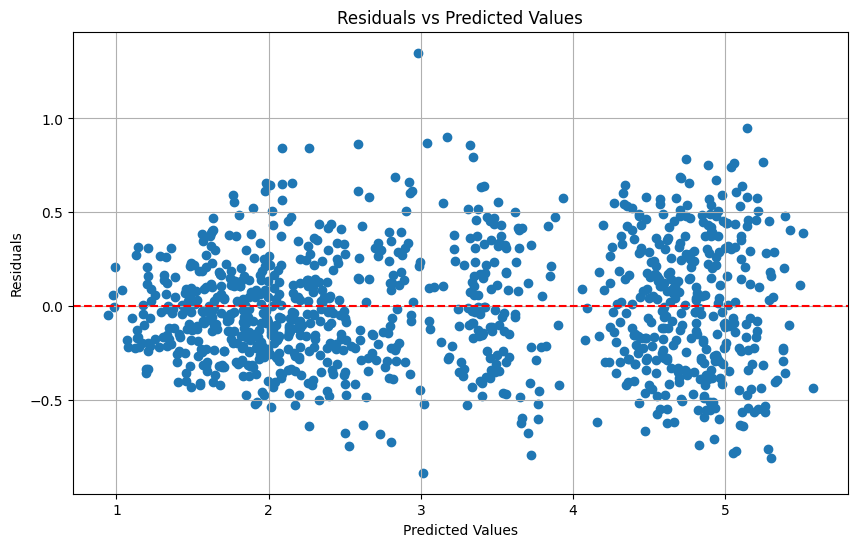

In [5]:
# 1. Residuals Plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid()
plt.show()

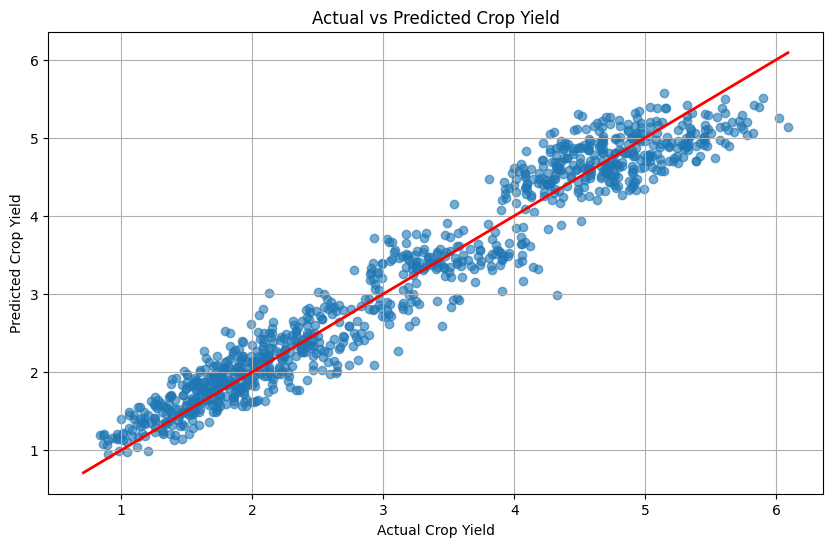

In [6]:
# 2. Actual vs Predicted Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linewidth=2)
plt.title('Actual vs Predicted Crop Yield')
plt.xlabel('Actual Crop Yield')
plt.ylabel('Predicted Crop Yield')
plt.grid()
plt.show()

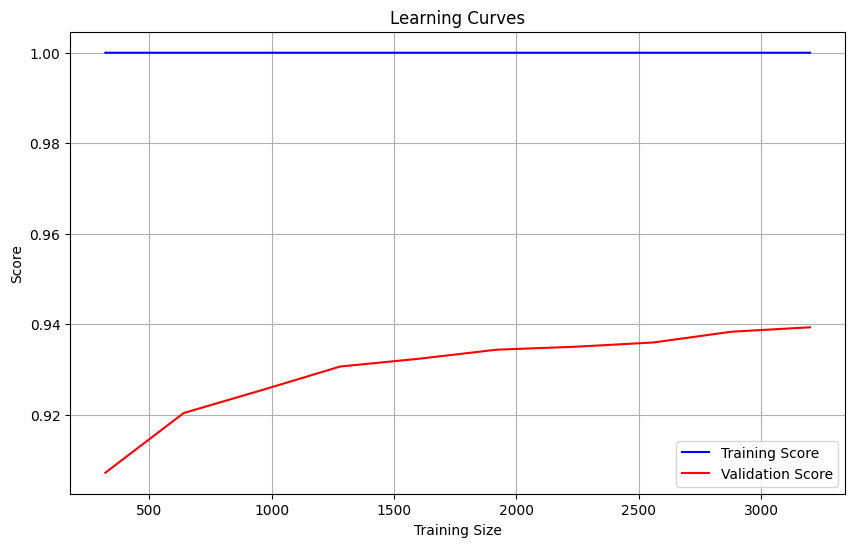

In [8]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(xgb_model, X_train_scaled, y_train, cv=5, n_jobs=-1,
                                                         train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Score', color='blue')
plt.plot(train_sizes, test_scores_mean, label='Validation Score', color='red')
plt.title('Learning Curves')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.legend()
plt.grid()
plt.show()


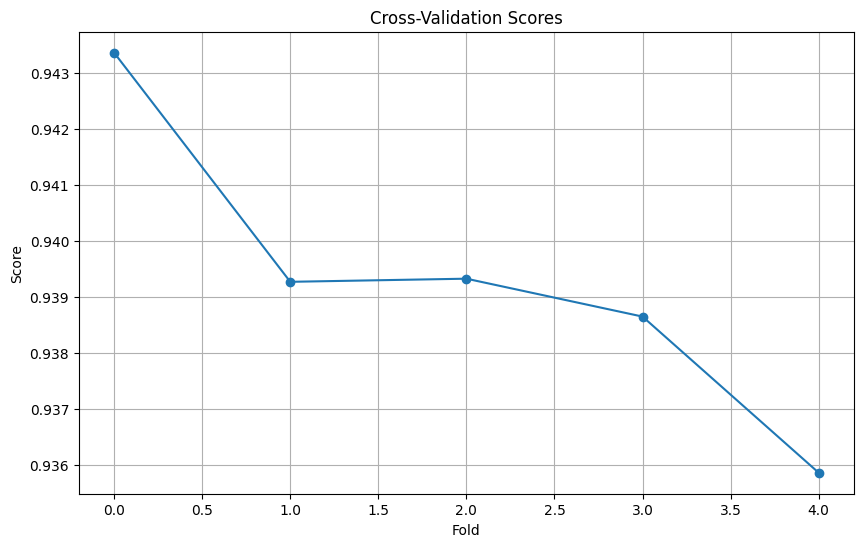

In [9]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(xgb_model, X_train_scaled, y_train, cv=5)
plt.figure(figsize=(10, 6))
plt.plot(cv_scores, marker='o')
plt.title('Cross-Validation Scores')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.grid()
plt.show()


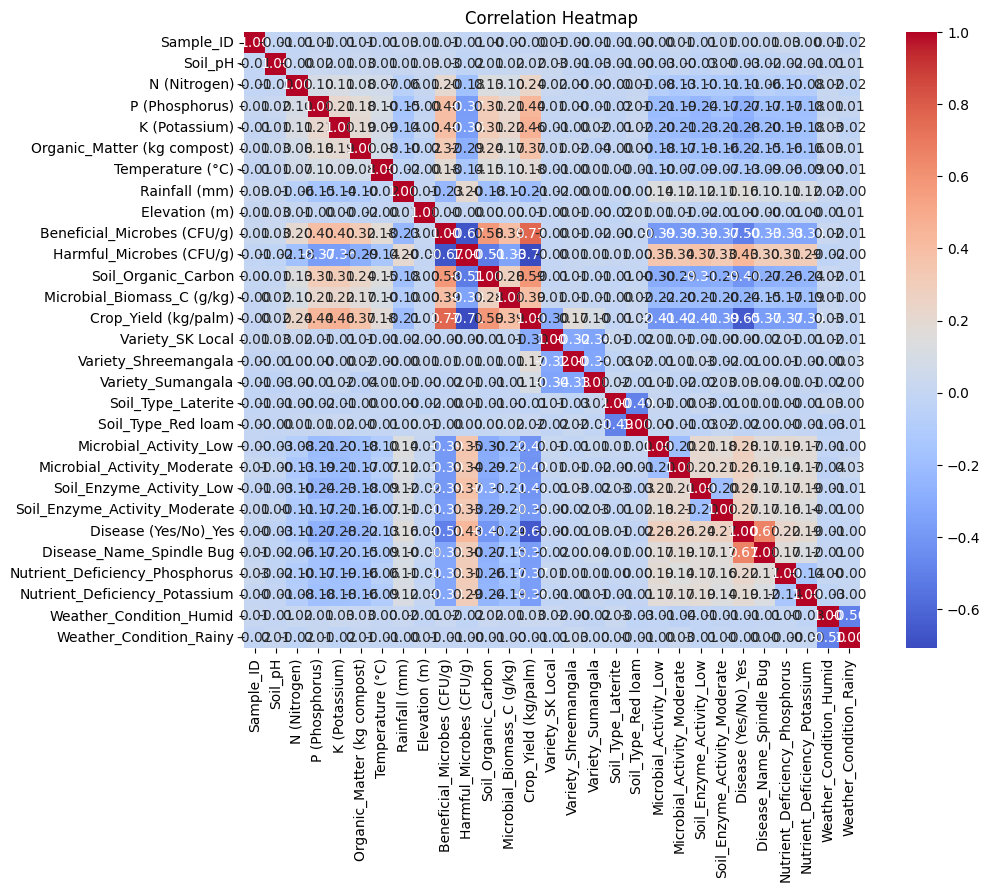

In [10]:
import seaborn as sns

plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()